In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl

2024-11-20 17:05:32.010034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import gymnasium as gym
import minigrid # Must import minigrid after gymnasium to register the environments properly.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
def generate_model_actor_classical_shared_mdp(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical_joint_mdp_central(n_agents: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()] # Flatten all inputs.
    layers += [keras.layers.Dense(u, activation=activation) for u in units] # Central branch dense layers.
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
from minigrid.core.world_object import Goal
class StepRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.last_pos = None
        self.goal_position: tuple = None
        
    def step(self, action):
        # Take the given action.
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Compute slope to goal.
        slope = np.divide(
            self.goal_position[1] - self.unwrapped.agent_pos[1],
            self.goal_position[0] - self.unwrapped.agent_pos[0],
        )
        slope = np.arctan(slope) # Angle.
        # print(f"{slope=}, {np.arctan(slope)=}")

        # # Give a negative reward for standing still.
        # if not terminated and self.last_pos is not None and self.unwrapped.agent_pos == self.last_pos:
        #     # print(f"matched pos")
        #     reward = -1.5
        # Give a negative reward for each step.
        if not terminated and reward == 0:
            # reward = +1. * 1./slope
            # reward = +1.
            reward = -1.
        # If we're terminating, then scale the reward by 100.
        elif terminated:
            reward = reward * 100.
            
        self.last_pos = self.unwrapped.agent_pos
        # print(f"{self.unwrapped.agent_pos=}")

        return obs, reward, terminated, truncated, info
    
    def reset(self, *args, **kwargs):
        obs, info = self.env.reset(*args, **kwargs)

        if not self.goal_position:
            self.goal_position = [
                x for x, y in enumerate(self.unwrapped.grid.grid) if isinstance(y, Goal)
            ]
            # in case there are multiple goals , needs to be handled for other env types
            if len(self.goal_position) >= 1:
                self.goal_position = (
                    int(self.goal_position[0] / self.unwrapped.height),
                    self.goal_position[0] % self.unwrapped.width,
                )
        
        # print(f"{self.goal_position=}, {self.unwrapped.agent_pos=}")

        return obs, info

In [6]:
import minigrid.wrappers


n_agents = 1
n_actions = 3 # 0=left, 1=right, 2=forward.
env_id = "MiniGrid-LavaGapS5-v0"
# env_id = "MiniGrid-Empty-5x5-v0"
# env_id = "MiniGrid-Empty-8x8-v0"
max_steps_per_episode = 150
env_vec = gym.vector.make(env_id, num_envs=n_agents, wrappers=[
    # minigrid.wrappers.ActionBonus,
    # minigrid.wrappers.PositionBonus,
    # minigrid.wrappers.FullyObsWrapper,
    lambda env: minigrid.wrappers.NoDeath(env, no_death_types=('lava',), death_cost=-2.),
    minigrid.wrappers.ImgObsWrapper,
    StepRewardWrapper,
    minigrid.wrappers.ActionBonus,
    # gym.RewardWrapper,
], render_mode="rgb_array", max_steps=max_steps_per_episode)
obs_shape = env_vec.observation_space.shape[1:]
obs_shape

(7, 7, 3)

In [7]:
# units = [12]
# units = [48, 24, 12]
# units = [32]
units = [100]
learning_rate = 1.0e-3
# learning_rate = 1.0e-2 # Causes action probabilities to go to NaN.
# learning_rate = 1.0e-4 
model_actor = generate_model_actor_classical_shared_mdp(
    n_actions=n_actions,
    units=units,
    name='fctde-actor',
)
model_actor.build([None, *obs_shape])
optimizer_actor = keras.optimizers.Adam(learning_rate=learning_rate)
model_critic = generate_model_critic_classical_joint_mdp_central(
    n_agents=n_agents,
    units=units,
    name='fctde-critic',
)
model_critic.build([None, n_agents, *obs_shape])
optimizer_critic = keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
algo = eqmarl.algorithms.MAA2C(
    env=env_vec,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=0.99,
    # gamma=0.95,
    alpha=0.001,
    # alpha=0.01,
    # alpha=0.1,
    # epsilon=0.1,
    # epsilon=0.3,
    # epsilon=0.4,
    )

In [9]:
n_episodes = 1000
reward_history, metrics_history = algo.train(
    n_episodes=n_episodes,
    max_steps_per_episode=max_steps_per_episode,
)

Training for 1000 episodes, press 'Ctrl+C' to terminate early
Episode 0:   0%|          | 0/1000 [00:00<?, ?episode/s]

/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_93056/1695852895.py:13: RuntimeWarning: divide by zero encountered in divide
/var/folders/5k/47hxnf0d2v1cvrggbx8z9ts40000gn/T/ipykernel_93056/1695852895.py:13: RuntimeWarning: invalid value encountered in divide


Episode 1000: 100%|██████████| 1000/1000 [00:48<00:00, 20.49episode/s, episode_reward=[81.16541451]]


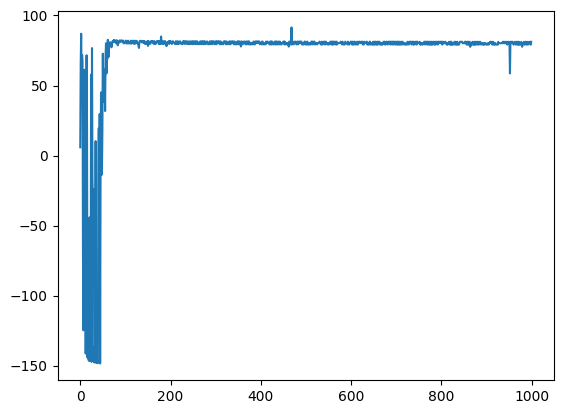

In [10]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.plot(x, y)

In [11]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate(imgs: list, type='js'): # 'js' or 'html'

    # Create figure and axes
    fig, ax = plt.subplots()

    def _animate(i):
        ax.clear()
        ax.imshow(imgs[i])

    anim = animation.FuncAnimation(fig, _animate, frames=len(imgs), interval=200)

    # Convert the animation to HTML5 video
    # HTML(anim.to_html5_video())
    if type == 'js':
        return HTML(anim.to_jshtml())
    else:
        return HTML(anim.to_html5_video())

In [12]:
def run(env, model_actor):
    actions = []
    rewards = []
    imgs = []
    # obs, info = env.reset(seed=42)
    s, info = env.reset()
    imgs.append(env.render())
    for t in range(max_steps_per_episode):
        s = tf.convert_to_tensor(s)
        s = tf.reshape(s, (-1, *s.shape))
        # print(f"{s.shape=}")

        action_probs = model_actor(s)
        
        # Sample action from estimated probability distribution.
        action = np.random.choice(action_probs.shape[-1], p=np.squeeze(action_probs))
        
        s, reward, terminated, truncated, info  = env.step(action)
        actions.append(action)
        rewards.append(reward)
        
        img = env.render()
        imgs.append(img)
        
        # print(f"{t=}, {reward=}, {action=}, {terminated=}")
        
        if terminated:
            break
    return imgs, actions, rewards

In [13]:
env = gym.make(env_id, render_mode="rgb_array")
env = minigrid.wrappers.ImgObsWrapper(env)
env = StepRewardWrapper(env)
imgs, _, _ = run(env, model_actor)
print(f"{len(imgs)-1} steps")

1 steps


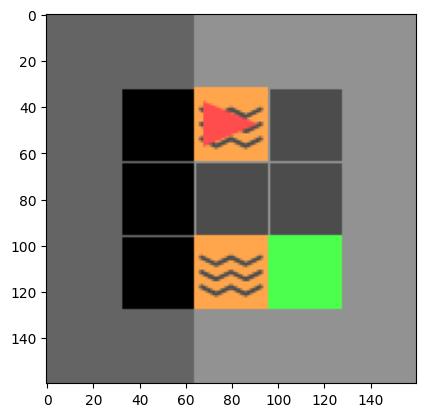

In [14]:
animate(imgs, type='js')

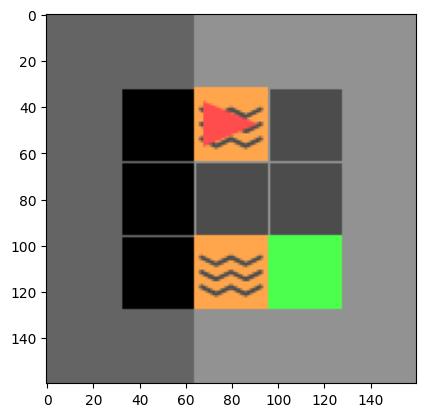

In [15]:
animate(imgs, type='html')